In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)
%cd /content/gdrive/MyDrive/

Mounted at /content/gdrive
/content/gdrive/MyDrive


In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pickle as pkl

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
class load(Dataset):
    def __init__(self, path, train = True, transform = None):
        self.transform = transform
        path = path + ('train/' if train else 'test/')
        self.pathx = path + 'X/'
        self.pathy = path + 'Y/'
        self.data = os.listdir(self.pathx)
    def __getitem__(self, idx):
        f = self.data[idx]
        img0 = cv2.imread(self.pathx + f + '/rgb/0.png')
        img1 = cv2.imread(self.pathx + f + '/rgb/1.png')
        img2 = cv2.imread(self.pathx + f + '/rgb/2.png')
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        depth = np.load(self.pathx + f + '/depth.npy')
        field_id = pkl.load(open(self.pathx + f + '/field_id.pkl', 'rb'))
        y = np.load(self.pathy + f + '.npy')
        return (img0, img1, img2, depth, torch.tensor(int(field_id))), torch.tensor(y)
    def __len__(self):
        return len(self.data)

In [ ]:
data_train = load('./lazydata/', train = True)
data_test = load('./lazydata/', train = False)

In [ ]:
(img0, img1, img2, depth, field_id), y = data_train[0]

In [ ]:
img0.shape, img1.shape, img2.shape, depth.shape, y.shape

((224, 224, 3),
 (224, 224, 3),
 (224, 224, 3),
 (3, 224, 224),
 torch.Size([10, 10]))

In [ ]:
field_id

3499

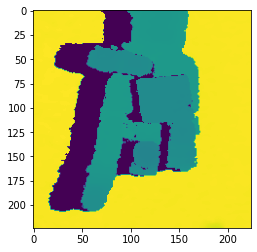

In [ ]:
plt.imshow(depth[0])
plt.show()

In [ ]:
class neural_network(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.relu = nn.ReLU()
    self.linear1 = nn.Linear(28 * 28, 512)
    self.linear2 = nn.Linear(512, 512)
    self.linear3 = nn.Linear(512, 10)
  def forward(self, x):
    x = self.flatten(x)
    x = self.relu(self.linear1(x))
    x = self.relu(self.linear2(x))
    logits = self.linear3(x)
    return logits

In [ ]:
model = neural_network()
x = torch.Tensor(10, 28, 28)
y = model(x)
y.shape

torch.Size([10, 10])

In [ ]:
model = neural_network().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3)

In [ ]:
def tuple_to_tensor(tensor_tuple):
    tensors = []
    for i in tensor_tuple:
        tensors.append(torch.tensor(i))
    return torch.stack(tensors, dim = 0)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
  size = len(data_train)
  model.train()
  for batch, (x, y) in enumerate(data_train):
    x = tuple_to_tensor(x)
    x, y = x.to(device), y.to(device)
    pred = model(x)
    loss = loss_fn(pred, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if batch % 100 == 0:
      loss, current = loss.item(), batch * len(x)
      print(f'loss: {loss:>7f} [{current:>5d} / {size:>5d}]')

In [ ]:
def test(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batch = len(dataloader)
  model.eval()
  test_loss, correct = 0, 0
  with torch.no_grad():
    for x, y in dataloader:
      x, y = x.to(device), y.to(device)
      pred = model(x)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  test_loss /= num_batch
  correct /= size
  print(f'test error \n accuracy: {(100 * correct):>0.1f} %, avg loss: {test_loss:>8f} \n')

In [ ]:
epoch = 1
for t in range(epoch):
  print(f'epoch {t + 1}\n')
  train(data_train, model, loss_fn, optimizer)
  test(data_test, model, loss_fn)

epoch 1

<class 'list'>


RuntimeError: ignored